In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import statistics
import matplotlib.pyplot as plt
import datetime
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler


# Ignore all warnings
warnings.filterwarnings('ignore')

# If you specifically want to ignore warnings from pandas, you can do so as follows
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')


# Set options to display all columns
pd.set_option('display.max_columns', None)

# Optionally, set the display width to ensure that pandas does not wrap text
pd.set_option('display.width', None)

# Set the column display length to maximum
pd.set_option('display.max_colwidth', None)

In [2]:

def granger_test(filename, granger_test_data):
    
    global lag
    
    try:
        gc_test = grangercausalitytests(granger_test_data, maxlag=lag, verbose=False)

        # Initialize an empty list to store F test p-values
        f_test_p_values = []
        chi2_test_p_values = []

        # Iterate through the Granger causality test results to extract the F test p-values
        for lag in range(1, lag+1):
            p_value_f = gc_test[lag][0]['ssr_ftest'][1]  # Extracting the p-value
            p_value_chi = gc_test[lag][0]['ssr_chi2test'][1]  # Extracting the p-value
            f_test_p_values.append(round(p_value_f,5))
            chi2_test_p_values.append(round(p_value_chi,5))

        return f_test_p_values, chi2_test_p_values, True
    except:
        # In case of an exception, return lists of 1's of length equal to `lag`
        # print(f"File '{filename}' Granger analysis failed.")
        return [1] * lag, [1] * lag, False

def data_transformer(data):

    data = data.sort_values(by='Date')
    data = data.reset_index(drop=True)
        
    # Update the DataFrame's column names
    new_columns = [col.replace(" - Realtime", "") for col in data.columns]
    data.columns = new_columns
    
    for column in data.select_dtypes(include=['object']).columns:
    # Replace "," with "." in the entire column and convert the column to float
        if column != "Date":
            data[column] = data[column].str.replace(",", ".").astype(float)
    
    
    #Make the modifications for the analysis
    data = data.dropna(subset=["(R1) Close", "Twitter Positive Sentiment Count", "Twitter Negative Sentiment Count"])
    
    # data["Twitter Sentiment Count"] = data["Twitter Positive Sentiment Count"] - data["Twitter Negative Sentiment Count"]    
    # data = data[data['Twitter Sentiment Count'] != 0]
    
    
    #Drop the rows where the Twitter Sentiment Count is 0 because the % change is not calculable at these values
    
    data['Log Returns'] = np.log(data['(R1) Close'] / data['(R1) Close'].shift(1))
    data['Log Returns Variance'] = data['Log Returns'] ** 2 *100
    #data['Log Returns Variance'] = np.absolute(data['Log Returns'])
    
    
    # data['Daily Sentiment Change'] = data['Twitter Sentiment Count'].pct_change()
    
    
    #CHANGE!
    # data['Daily Sentiment Change'] = data['Twitter Publication Count (L1)'].pct_change()
    # data['Daily Sentiment Change'] = data["Twitter Positive Sentiment Count"] / data['Twitter Publication Count (L1)']
    data['Daily Sentiment Change'] = -data["Twitter Negative Sentiment Count"]   / data['Twitter Publication Count (L1)']*100
    # data['Daily Sentiment Change'] = -data["Twitter Negative Sentiment Count"]   / data['Twitter Publication Count (L1)']
    

    data = data.replace(np.inf, 0)
    data = data.dropna(subset=["Daily Sentiment Change", "Log Returns"])
    
    
    scaler = StandardScaler()
    try:
        data['Log Returns Variance'] = scaler.fit_transform(data['Log Returns Variance'].values.reshape(-1,1))
        data['Daily Sentiment Change'] = scaler.fit_transform(data['Daily Sentiment Change'].values.reshape(-1,1))
    except:
        pass
    
    return data
    

def extract_irf_data(irf):
    global round_value
    global round_value
    
    # Get standard errors of the impulse response functions
    std_errors = irf.stderr()

    # Calculate lower 5% significance value
    lower_5_significance = irf.irfs -1.96* std_errors  # Assuming normal distribution
    # lower_5_significance = irf.irfs -1.645* std_errors  # Assuming normal distribution
    #10%-os szorzó ennyi lenne   
    irf_array=irf.irfs
    # Number of time periods is length of the array - 1
    time_periods = len(irf_array) - 1
    
    # Initialize lists to hold the IRF data for each variable's response
    lr_to_lr = [] # Log Returns Variance → Log Returns Variance
    ds_to_lr = []  # Daily Sentiment Change → Log Returns Variance
    lr_to_ds = [] # Log Returns Variance → Daily Sentiment Change
    ds_to_ds = []  # Daily Sentiment Change → Daily Sentiment Change

    # Extract data for each time period
    for t in range(0, time_periods + 1):  # start from 1 to skip the immediate response
        
        lr_to_lr.append(round(irf_array[t][0][0],round_value))
        ds_to_lr.append(round(irf_array[t][0][1],round_value))
        lr_to_ds.append(round(irf_array[t][1][0],round_value))
        ds_to_ds.append(round(irf_array[t][1][1],round_value))
        
    # Initialize lists to hold the IRF lower 5% sigificance data for each variable's response
    lr_to_lr_lower = [] # Log Returns Variance → Log Returns Variance
    ds_to_lr_lower = []  # Daily Sentiment Change → Log Returns Variance
    lr_to_ds_lower = [] # Log Returns Variance → Daily Sentiment Change
    ds_to_ds_lower = []  # Daily Sentiment Change → Daily Sentiment Change
    
    # Extract data for each time period
    for t in range(0, time_periods + 1):  # start from 1 to skip the immediate response
        lr_to_lr_lower.append(round(lower_5_significance[t][0][0],round_value))
        ds_to_lr_lower.append(round(lower_5_significance[t][0][1],round_value))
        lr_to_ds_lower.append(round(lower_5_significance[t][1][0],round_value))
        ds_to_ds_lower.append(round(lower_5_significance[t][1][1],round_value))

    # Combine the lists into a tuple
    irf_data_tuple = (lr_to_lr, ds_to_lr, lr_to_ds, ds_to_ds)
    irf_lower_data_tuple=(lr_to_lr_lower, ds_to_lr_lower, lr_to_ds_lower, ds_to_ds_lower)
    
    return irf_data_tuple,irf_lower_data_tuple

def irf_analysis(data, irf_len):
    global lag
    
    # Prepare the dataset for VAR model
    var_data = data[['Log Returns Variance', 'Daily Sentiment Change']].dropna()

    # Create the VAR model
    model = VAR(var_data)
    try:
        model_fitted = model.fit(maxlags=lag, ic='aic')
        impulse_response_data = model_fitted.irf(irf_len)
        irf_data,irf_lower_data=extract_irf_data(impulse_response_data)
    except:
        return None,None
    return irf_data,irf_lower_data

In [3]:
cwd = Path.cwd()
filename = "S&P500.xlsx"
file_path = cwd.parent / filename

sp500_data = pd.read_excel(file_path)
sp500 = sp500_data["Ticker"]
sp500 = sp500.str.replace("/", "_")

#Módosítás_1
#Itt lehet beállítani a főbb paramétereket a program futtatásához

#A granger okság számításához használt maximális lag
lag = 10

#Az a szignifikancia szint, ami felett elfogadjuk a granger okságot
threshold = 0.01

#Az impulzus válasz függvény lag-jainak száma
length_of_irf = 50

#Az ábrázolni kívánt chartok száma az IRF ábrázolásnál. Ha csak 2 paraméter között vizsgálunk, akkor 4 chart kell
number_of_charts = 4

#A módusz kerekítési értéke (hány tizedes)
round_value = 8

# Az IRF ábrázolásnál mennyi középső értéket tartunk meg a min és max értékek leválasztása előtt
keep_value = 0.8  # Example keep value, e.g., keep the middle 95% of the data


#Legyen dátum szűrés a vizsgálatban? Ha igen, akkor az ezt követő dátumokra vizsgáljuk az adatokat
date_filtering = False
start_year, start_month, start_day = 2023, 3, 14
end_year, end_month, end_day = 2023, 3, 14

# sp500 = sp500.head(5)
data_folder = "Twitter_Daily_5Y"

In [4]:
F_test_P_lag_sent_list = []
F_test_P_lag_ret_list = []

for i in range(1, lag+1):
    # print(i)
    F_test_P_lag_sent_list.append(f"F_test_P_lag_sent_{i}")
    F_test_P_lag_ret_list.append(f"F_test_P_ret_sent_{i}")
    
results_df = pd.DataFrame(columns=['Ticker',"Stationarity", "Twitter_sum","Twitter_avg","Twitter_median", "Twitter_negative_sum","Twitter_negative_avg","Twitter_negative_median", "Twitter_positive_sum","Twitter_positive_avg","Twitter_positive_median", *F_test_P_lag_sent_list, *F_test_P_lag_ret_list])


In [5]:
irf_results = [[[[]for _ in range(length_of_irf+1)] for _ in range(number_of_charts)] for _ in range(2)]
# print(irf_results)
stationary_failed_count = 0
granger_failed_count = 0
VAR_failed_count = 0

for filename_raw in sp500:
    filename = filename_raw + ".csv"
    file_path = cwd.parent / data_folder / filename
    # file_path = cwd / data_folder / filename

    if os.path.isfile(file_path):
        data = pd.read_csv(file_path)
        short_ticker = filename_raw.split(" ")[0]
        print(f"{short_ticker} loaded successfully.")
        
        # Analyze the data and get results
        data = data_transformer(data)
        # print(data)
        
        if date_filtering:
            data['Date'] = pd.to_datetime(data['Date'])
            data = data[data['Date'] > datetime.datetime(start_year, start_month, start_day)]
            data = data[data['Date'] < datetime.datetime(end_year, end_month, end_day)]
            
            
        try:
            stationary_result = adfuller(data['Log Returns Variance'])
            stationary_result_2 = adfuller(data['Daily Sentiment Change'])
            test_failed = False
        except:
            print("The stationary test could not run.")
            stationary_failed_count += 1
            f_test_p_values_0, f_test_p_values_1 = [1] * lag, [1] * lag
            stationary_result = [0,0] 
            stationary_result_2 = [0,0] 
            test_failed = True

        # Initialize a flag to track if any of the previous tests failed

        if stationary_result[1] >= threshold:
            print(f"The '{short_ticker}' Log Returns Variance - time series is non-stationary.")
            stationary_failed_count += 1
            f_test_p_values_0, f_test_p_values_1 = [1] * lag, [1] * lag
            test_failed = True

        elif stationary_result_2[1] >= threshold:
            print(f"The '{short_ticker}' Daily Sentiment Change - time series is non-stationary.")
            stationary_failed_count += 1
            f_test_p_values_0, f_test_p_values_1 = [1] * lag, [1] * lag
            test_failed = True

        if not test_failed:
            stationarity = "Yes"
            f_test_p_values_0, chi2_test_p_values_0, granger_succes_0 = granger_test(short_ticker, data[['Log Returns Variance', 'Daily Sentiment Change']])
            f_test_p_values_1, chi2_test_p_values_1, granger_succes_1 = granger_test(short_ticker, data[['Daily Sentiment Change', 'Log Returns Variance']])
            
            if not granger_succes_0 and not granger_succes_1:
                granger_failed_count += 1
                print(f"File '{short_ticker}' Granger analysis failed.")
        else:
            stationarity = "No"
            granger_succes_0 = False
            granger_succes_1 = False
        
        
        
        state_0 = True if np.any(threshold > np.array(f_test_p_values_0)) else False
        state_1 = True if np.any(threshold > np.array(f_test_p_values_1)) else False
        
         
        # if state_0 or state_1:
        if state_0 and (granger_succes_0 or granger_succes_1):
            irf_data,irf_lower_data = irf_analysis(data, length_of_irf)
            
            if irf_data == None:
                VAR_failed_count += 1
                print(f"File '{short_ticker}' VAR analysis failed.")
            else:
                # print(irf_data)
                for id_chart, chart_list in enumerate(irf_data):
                    for id_value, value_position in enumerate(chart_list):
                        irf_results[0][id_chart][id_value].append(value_position)
                        
                for id_chart, chart_list in enumerate(irf_lower_data):
                    for id_value, value_position in enumerate(chart_list):
                        irf_results[1][id_chart][id_value].append(value_position)

        elif not state_0 and granger_succes_0 or granger_succes_1:
            print(f"File '{short_ticker}' Granger analysis resulted bellow significance.")
            
        # Create a temporary DataFrame with structured data
        temp_df = pd.DataFrame([[
            short_ticker,
            stationarity,
            data['Twitter Publication Count (L1)'].sum(),
            data['Twitter Publication Count (L1)'].mean().__round__(round_value),
            data['Twitter Publication Count (L1)'].median().__round__(round_value),
            
            data["Twitter Negative Sentiment Count"].sum(),
            data["Twitter Negative Sentiment Count"].mean().__round__(round_value),
            data["Twitter Negative Sentiment Count"].median().__round__(round_value),
            
            data["Twitter Positive Sentiment Count"].sum(),
            data["Twitter Positive Sentiment Count"].mean().__round__(round_value),
            data["Twitter Positive Sentiment Count"].median().__round__(round_value),
            *f_test_p_values_0,  # Unpack the f_test_p_values_0 list
            *f_test_p_values_1   # Unpack the f_test_p_values_1 list
        ]], columns=results_df.columns)
        
        # Concatenate temp_df with results_df and update results_df
        results_df = pd.concat([results_df, temp_df], ignore_index=True)
    else:
        print(f"File '{filename}' does not exist in the {data_folder} folder.")
    # print("\n")

# Assuming you want to view the results_df DataFrame after the loop
print("\nFailed stationary tests:", stationary_failed_count)
print("Failed granger causality tests:", granger_failed_count)
print("Failed VAR analyis:", VAR_failed_count)
results_df

MSFT loaded successfully.
File 'MSFT' Granger analysis resulted bellow significance.
AAPL loaded successfully.
The 'AAPL' Daily Sentiment Change - time series is non-stationary.
NVDA loaded successfully.
AMZN loaded successfully.
File 'AMZN' Granger analysis resulted bellow significance.
GOOG loaded successfully.
File 'GOOG' Granger analysis resulted bellow significance.
META loaded successfully.
The 'META' Daily Sentiment Change - time series is non-stationary.
BRK_B loaded successfully.
File 'BRK_B' Granger analysis resulted bellow significance.
LLY loaded successfully.
File 'LLY' Granger analysis resulted bellow significance.
TSLA loaded successfully.
File 'TSLA' Granger analysis resulted bellow significance.
AVGO loaded successfully.
The 'AVGO' Daily Sentiment Change - time series is non-stationary.
V loaded successfully.
JPM loaded successfully.
File 'JPM' Granger analysis resulted bellow significance.
UNH loaded successfully.
File 'UNH' Granger analysis resulted bellow significan

,Ticker,Stationarity,Twitter_sum,Twitter_avg,Twitter_median,Twitter_negative_sum,Twitter_negative_avg,Twitter_negative_median,Twitter_positive_sum,Twitter_positive_avg,Twitter_positive_median,F_test_P_lag_sent_1,F_test_P_lag_sent_2,F_test_P_lag_sent_3,F_test_P_lag_sent_4,F_test_P_lag_sent_5,F_test_P_lag_sent_6,F_test_P_lag_sent_7,F_test_P_lag_sent_8,F_test_P_lag_sent_9,F_test_P_lag_sent_10,F_test_P_ret_sent_1,F_test_P_ret_sent_2,F_test_P_ret_sent_3,F_test_P_ret_sent_4,F_test_P_ret_sent_5,F_test_P_ret_sent_6,F_test_P_ret_sent_7,F_test_P_ret_sent_8,F_test_P_ret_sent_9,F_test_P_ret_sent_10
0,MSFT,Yes,1248135.0,994.529880,821.0,-61041.0,-48.638247,-30.0,76460.0,60.924303,36.0,0.10191,0.26994,0.14078,0.30197,0.45121,0.55873,0.57426,0.61862,0.60753,0.30183,0.03195,0.04977,0.10110,0.22390,0.34716,0.46715,0.56570,0.63667,0.71863,0.75799
1,AAPL,No,1847401.0,1472.032669,1214.0,-50353.0,-40.121912,-25.0,37902.0,30.200797,15.0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
2,NVDA,Yes,1123226.0,895.714514,464.0,-58719.0,-46.825359,-25.0,93981.0,74.944976,40.0,0.00035,0.00699,0.01269,0.03974,0.08438,0.16337,0.25492,0.34195,0.40844,0.36773,0.12718,0.52528,0.67191,0.53576,0.52655,0.56930,0.71590,0.77610,0.81346,0.87130
3,AMZN,Yes,1697852.0,1352.870120,1242.0,-93719.0,-74.676494,-54.0,84334.0,67.198406,48.0,0.56845,0.62729,0.82549,0.58342,0.64902,0.78418,0.79622,0.88436,0.94407,0.78656,0.91914,0.36083,0.06527,0.11958,0.09951,0.15131,0.22255,0.27522,0.38270,0.41229
4,GOOG,Yes,2287905.0,1823.031873,1801.0,-115354.0,-91.915538,-64.0,61882.0,49.308367,35.0,0.44379,0.47080,0.08687,0.23435,0.04355,0.04181,0.07287,0.10517,0.06273,0.02370,0.00415,0.00075,0.00405,0.00134,0.00206,0.00479,0.00717,0.01126,0.01105,0.01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CMA,Yes,6582.0,10.365354,6.0,-601.0,-0.946457,0.0,736.0,1.159055,0.0,0.02175,0.04562,0.10413,0.27375,0.34631,0.33391,0.38954,0.51642,0.49462,0.58950,0.24899,0.18191,0.60429,0.38752,0.65591,0.62652,0.69867,0.22792,0.33883,0.43737
496,FMC,Yes,4270.0,7.517606,4.0,-342.0,-0.602113,0.0,572.0,1.007042,0.0,0.06338,0.13435,0.38685,0.55660,0.49263,0.59498,0.48401,0.43525,0.57503,0.65669,0.19433,0.24376,0.35268,0.30137,0.37971,0.41877,0.52582,0.67233,0.78569,0.85619
497,VFC,No,8920.0,12.269601,7.0,-946.0,-1.301238,0.0,947.0,1.302613,0.0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
498,ZION,No,4818.0,8.603571,4.0,-424.0,-0.757143,0.0,444.0,0.792857,0.0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [6]:
#calculates how many times the values are below the threshold for each column

print(r"How many times (% of total) the null hypothesis was rejected for the Granger causality test")
F_test_P_lag_sent_list.extend(F_test_P_lag_ret_list)
ftest_count = results_df.shape[1] - len(F_test_P_lag_sent_list)
count_below = (results_df.iloc[:, ftest_count:] < threshold).sum()
total_count = len(results_df)
percentage_below = round((count_below / (total_count-stationary_failed_count)) * 100,0)
percentage_below_str = percentage_below.astype(int).astype(str) + '%'

print(f"\n{results_df.columns[5].replace('_sum','')}\nSignificance level: {threshold}")
percentage_below_str

How many times (% of total) the null hypothesis was rejected for the Granger causality test

Twitter_negative
Significance level: 0.01


F_test_P_lag_sent_1      9%
F_test_P_lag_sent_2     10%
F_test_P_lag_sent_3     10%
F_test_P_lag_sent_4     10%
F_test_P_lag_sent_5      7%
F_test_P_lag_sent_6      7%
F_test_P_lag_sent_7      7%
F_test_P_lag_sent_8      8%
F_test_P_lag_sent_9      7%
F_test_P_lag_sent_10     6%
F_test_P_ret_sent_1     21%
F_test_P_ret_sent_2     19%
F_test_P_ret_sent_3     19%
F_test_P_ret_sent_4     15%
F_test_P_ret_sent_5     14%
F_test_P_ret_sent_6     13%
F_test_P_ret_sent_7     14%
F_test_P_ret_sent_8     12%
F_test_P_ret_sent_9     11%
F_test_P_ret_sent_10    11%
dtype: object

In [7]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ticker                   500 non-null    object 
 1   Stationarity             500 non-null    object 
 2   Twitter_sum              500 non-null    float64
 3   Twitter_avg              499 non-null    float64
 4   Twitter_median           499 non-null    float64
 5   Twitter_negative_sum     500 non-null    float64
 6   Twitter_negative_avg     499 non-null    float64
 7   Twitter_negative_median  499 non-null    float64
 8   Twitter_positive_sum     500 non-null    float64
 9   Twitter_positive_avg     499 non-null    float64
 10  Twitter_positive_median  499 non-null    float64
 11  F_test_P_lag_sent_1      500 non-null    float64
 12  F_test_P_lag_sent_2      500 non-null    float64
 13  F_test_P_lag_sent_3      500 non-null    float64
 14  F_test_P_lag_sent_4      5

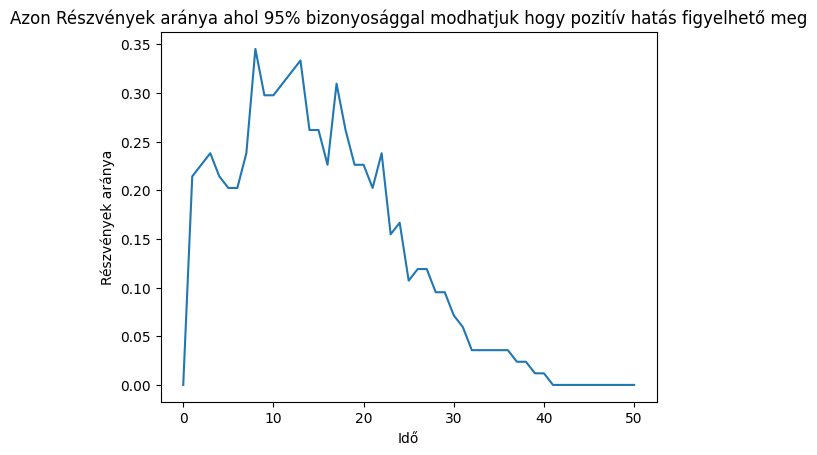

In [8]:
median_list = [[] for _ in range(number_of_charts)]
min_list = [[] for _ in range(number_of_charts)]
max_list = [[] for _ in range(number_of_charts)]
lower_percantage_count=[[] for _ in range(number_of_charts)]

for chart_id, chart_data in enumerate(irf_results[0]):
    for data_list in chart_data:
        
        median_list[chart_id].append(np.median(data_list))
        
        # Calculate percentiles for keeping the central data portion
        lower_percentile = np.percentile(data_list, (1 - keep_value) / 2 * 100)
        upper_percentile = np.percentile(data_list, 100 - (1 - keep_value) / 2 * 100)
        
        # Trim data to keep only the values within the specified percentile range
        trimmed_data = [d for d in data_list if lower_percentile <= d <= upper_percentile]
        
        
        # Append min and max from the trimmed data
        if trimmed_data:  # Check if the list is not empty
            min_list[chart_id].append(np.min(trimmed_data))
            max_list[chart_id].append(np.max(trimmed_data))
        else:
            # Handle the case where trimming leaves the data list empty
            min_list[chart_id].append(np.min(data_list))
            max_list[chart_id].append(np.max(data_list))

#Number of stocks' lower 5% percantage below 0 in every lag:

for chart_id, chart_data in enumerate(irf_results[1]):
    for data_list in chart_data:
        count_below_zero=0
        for num in data_list:
            if num >0:
                count_below_zero += 1
        lower_percantage_count[chart_id].append(count_below_zero/len(data_list))

# print(min_list[:5])
# print(median_list[:5])
# print(max_list[:5])
plt.plot(lower_percantage_count[1])
plt.title("Azon Részvények aránya ahol 95% bizonyosággal modhatjuk hogy pozitív hatás figyelhető meg")
plt.xlabel('Idő')
plt.ylabel('Részvények aránya')
plt.show()

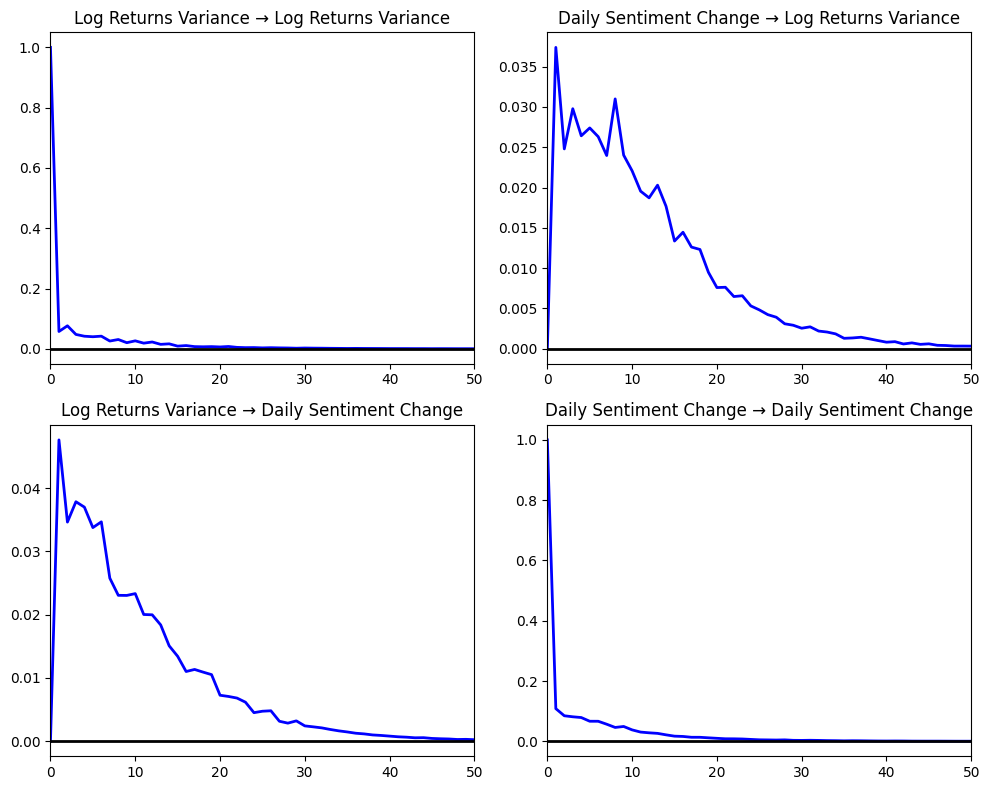

In [9]:
# Titles for the subplots
titles = [
    'Log Returns Variance → Log Returns Variance',
    'Daily Sentiment Change → Log Returns Variance',
    'Log Returns Variance → Daily Sentiment Change',
    'Daily Sentiment Change → Daily Sentiment Change'
]

# Time points (x-axis values)
time_points = range(len(median_list[0]))

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the impulse responses with a stronger continuous black line at y=0
for i, ax in enumerate(axs.flatten()):
    ax.plot(time_points, median_list[i], '-b', lw=2)  # Blue line
    ax.set_title(titles[i])
    ax.axhline(0, color='black', linewidth=2, linestyle='-')  # Make the zero line stronger and continuous
    ax.set_xlim([time_points[0], time_points[-1]])  # Set x-axis limits to match modus_list range

# Adjust layout
plt.tight_layout()

# Show the updated plots
plt.show()

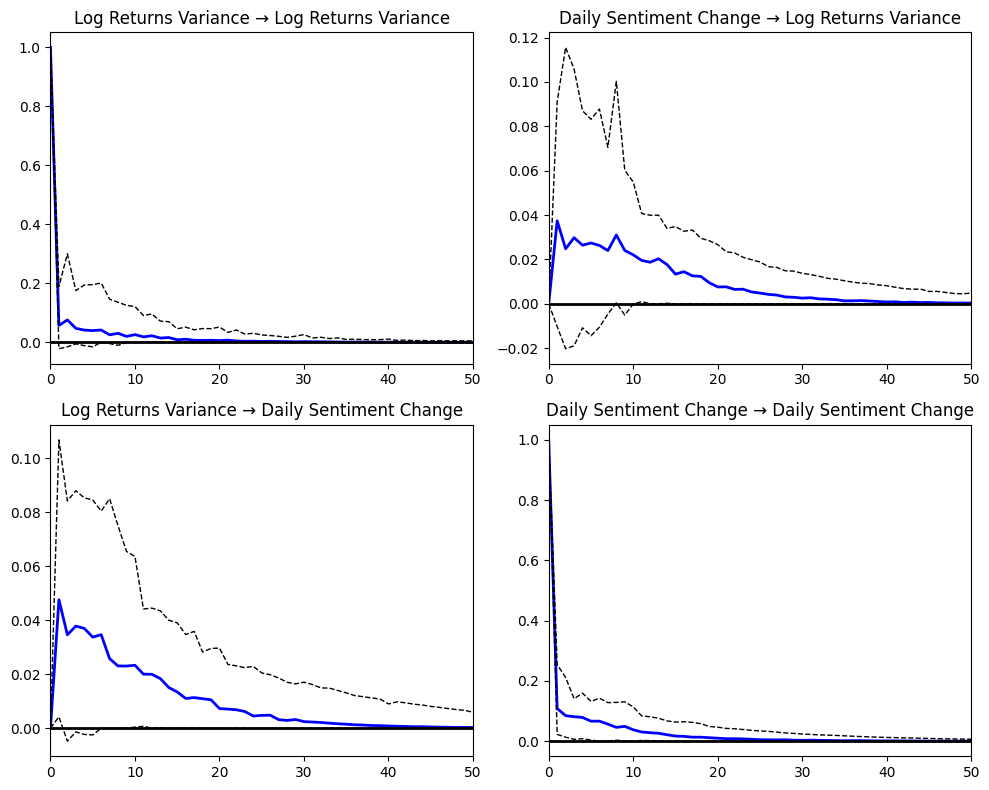

In [10]:
# Time points (x-axis values)
time_points = range(len(median_list[0]))

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the impulse responses with the specified line styles
for i, ax in enumerate(axs.flatten()):
    ax.plot(time_points, median_list[i], '-b', lw=2)  # Blue solid line for median
    ax.plot(time_points, min_list[i], '--k', lw=1)  # Black dashed line for min
    ax.plot(time_points, max_list[i], '--k', lw=1)  # Black dashed line for max
    ax.set_title(titles[i])
    ax.axhline(0, color='black', linewidth=2, linestyle='-')  # Make the zero line stronger and continuous
    ax.set_xlim([time_points[0], time_points[-1]])  # Set x-axis limits to match the list range

# Adjust layout
plt.tight_layout()

# Show the updated plots
plt.show()


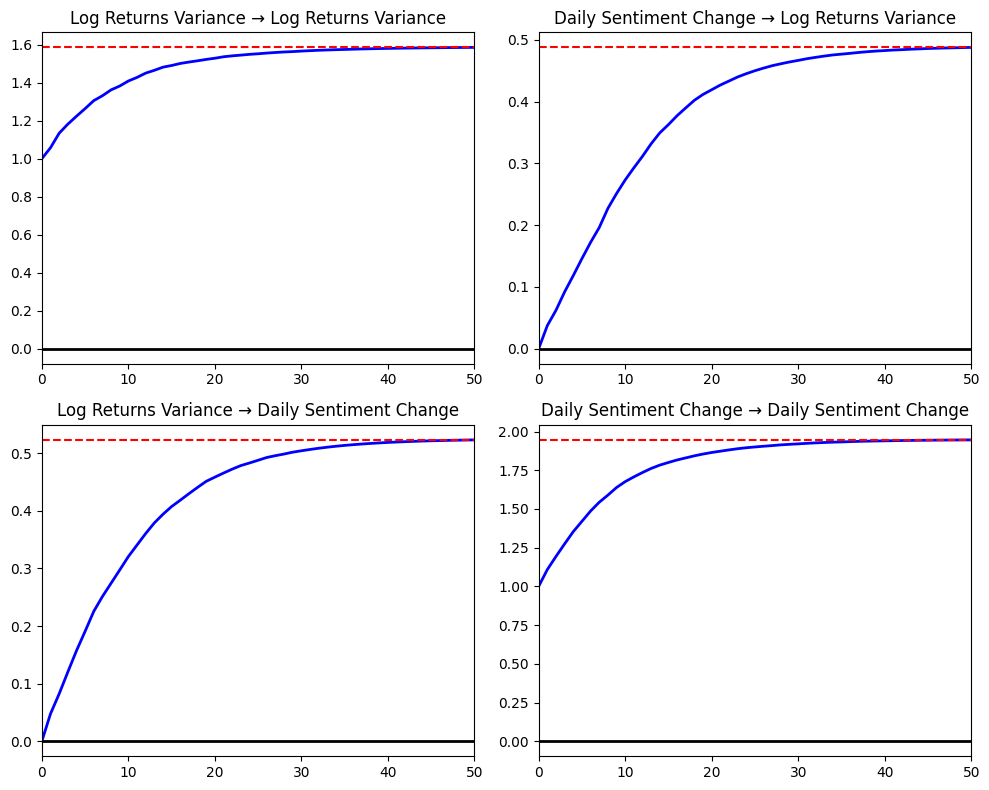

In [11]:
# Titles for the subplots
titles = [
    'Log Returns Variance → Log Returns Variance',
    'Daily Sentiment Change → Log Returns Variance',
    'Log Returns Variance → Daily Sentiment Change',
    'Daily Sentiment Change → Daily Sentiment Change'
]

cum_median= [np.cumsum(inner_list).tolist() for inner_list in median_list]
# Time points (x-axis values)
time_points = range(len(median_list[0]))

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the impulse responses with a stronger continuous black line at y=0
for i, ax in enumerate(axs.flatten()):
    ax.plot(time_points, cum_median[i], '-b', lw=2)  # Blue line
    ax.set_title(titles[i])
    ax.axhline(0, color='black', linewidth=2, linestyle='-')  # Make the zero line stronger and continuous
    ax.axhline(y=np.max(cum_median[i]), color='r', linestyle='--')
    ax.set_xlim([time_points[0], time_points[-1]])  # Set x-axis limits to match modus_list range
    
# Adjust layout
plt.tight_layout()

# Show the updated plots
plt.show()

In [12]:
# Determens if any of the lags had granger causality at the given threshold
results_df['Granger_true'] = results_df[[*F_test_P_lag_sent_list]].lt(threshold).any(axis=1)
# results_df = results_df[['Ticker', "Twitter_sum","Twitter_avg","Twitter_median", "Twitter_negative_sum","Twitter_negative_avg","Twitter_negative_median", "Twitter_positive_sum","Twitter_positive_avg","Twitter_positive_median",'Granger_true']]
results_df = results_df.drop([*F_test_P_lag_sent_list, *F_test_P_lag_ret_list], axis=1)

In [13]:
# results_df = pd.merge(results_df, sp500_data, on='Ticker', how='left')
sp500_data = sp500_data.rename(columns={'Ticker': 'Ticker_long'})

sp500_data = sp500_data[:len(results_df)]

results_df = pd.concat([results_df, sp500_data], axis=1)

results_df.head()

,Ticker,Stationarity,Twitter_sum,Twitter_avg,Twitter_median,Twitter_negative_sum,Twitter_negative_avg,Twitter_negative_median,Twitter_positive_sum,Twitter_positive_avg,Twitter_positive_median,Granger_true,Ticker_long,Name,Market_cap,Net_income,Sector
0,MSFT,Yes,1248135.0,994.529880,821.0,-61041.0,-48.638247,-30.0,76460.0,60.924303,36.0,False,MSFT UW Equity,Microsoft Corp,3.002342e+12,8.254100e+10,Technology
1,AAPL,No,1847401.0,1472.032669,1214.0,-50353.0,-40.121912,-25.0,37902.0,30.200797,15.0,False,AAPL UW Equity,Apple Inc,2.815209e+12,1.009130e+11,Technology
2,NVDA,Yes,1123226.0,895.714514,464.0,-58719.0,-46.825359,-25.0,93981.0,74.944976,40.0,True,NVDA UW Equity,NVIDIA Corp,1.793541e+12,1.888800e+10,Technology
3,AMZN,Yes,1697852.0,1352.870120,1242.0,-93719.0,-74.676494,-54.0,84334.0,67.198406,48.0,False,AMZN UW Equity,Amazon.com Inc,1.760765e+12,3.042500e+10,Consumer Cyclical
4,GOOG,Yes,2287905.0,1823.031873,1801.0,-115354.0,-91.915538,-64.0,61882.0,49.308367,35.0,True,GOOG UW Equity,Alphabet Inc,1.754656e+12,7.379500e+10,Communication Services


In [14]:
results_df.info()
notebook_name = "mass_analyzer_Twitter_negative_full_period"
results_df.to_csv(notebook_name+ ".csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ticker                   500 non-null    object 
 1   Stationarity             500 non-null    object 
 2   Twitter_sum              500 non-null    float64
 3   Twitter_avg              499 non-null    float64
 4   Twitter_median           499 non-null    float64
 5   Twitter_negative_sum     500 non-null    float64
 6   Twitter_negative_avg     499 non-null    float64
 7   Twitter_negative_median  499 non-null    float64
 8   Twitter_positive_sum     500 non-null    float64
 9   Twitter_positive_avg     499 non-null    float64
 10  Twitter_positive_median  499 non-null    float64
 11  Granger_true             500 non-null    bool   
 12  Ticker_long              500 non-null    object 
 13  Name                     500 non-null    object 
 14  Market_cap               5

In [15]:
# pd.set_option('display.max_rows', None)


percentage_below_str

F_test_P_lag_sent_1      9%
F_test_P_lag_sent_2     10%
F_test_P_lag_sent_3     10%
F_test_P_lag_sent_4     10%
F_test_P_lag_sent_5      7%
F_test_P_lag_sent_6      7%
F_test_P_lag_sent_7      7%
F_test_P_lag_sent_8      8%
F_test_P_lag_sent_9      7%
F_test_P_lag_sent_10     6%
F_test_P_ret_sent_1     21%
F_test_P_ret_sent_2     19%
F_test_P_ret_sent_3     19%
F_test_P_ret_sent_4     15%
F_test_P_ret_sent_5     14%
F_test_P_ret_sent_6     13%
F_test_P_ret_sent_7     14%
F_test_P_ret_sent_8     12%
F_test_P_ret_sent_9     11%
F_test_P_ret_sent_10    11%
dtype: object

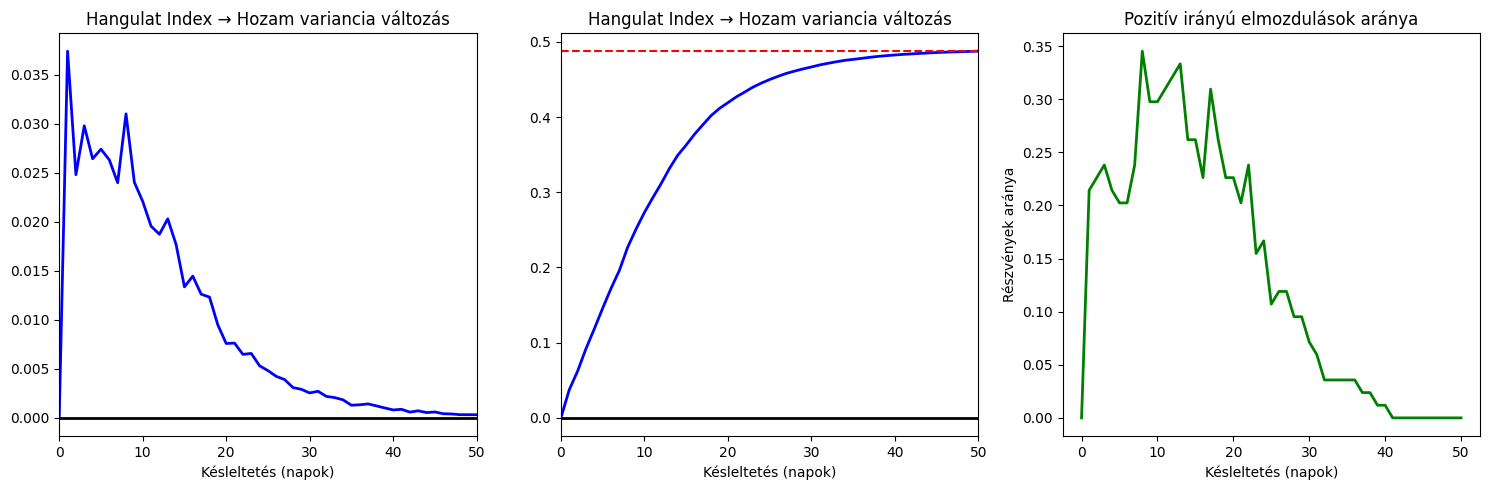

In [16]:
# Set up figure for 1 by 3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed for better display

# From cell_1
time_points = range(len(median_list[0]))
axs[0].plot(time_points, median_list[1], '-b', lw=2)  # Plotting second chart data
axs[0].axhline(0, color='black', linewidth=2, linestyle='-')
axs[0].set_title('Hangulat Index → Hozam variancia változás')
axs[0].set_xlim([time_points[0], time_points[-1]])
axs[0].set_xlabel('Késleltetés (napok)')

# From cell_2 (assuming cum_median is calculated as in cell_2)
cum_median = [np.cumsum(inner_list).tolist() for inner_list in median_list]
axs[1].plot(time_points, cum_median[1], '-b', lw=2)
axs[1].axhline(0, color='black', linewidth=2, linestyle='-')
axs[1].axhline(y=np.max(cum_median[1]), color='r', linestyle='--')
axs[1].set_title('Hangulat Index → Hozam variancia változás')
axs[1].set_xlim([time_points[0], time_points[-1]])
axs[1].set_xlabel('Késleltetés (napok)')

# From cell_3 (assuming lower_percantage_count is calculated as in cell_3)
axs[2].plot(time_points, lower_percantage_count[1], '-g', lw=2)
axs[2].set_title('Pozitív irányú elmozdulások aránya')
axs[2].set_xlabel('Késleltetés (napok)')
axs[2].set_ylabel('Részvények aránya')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
